# Rotated Object Detection

In this tutorial, you will learn:
- the basic structure of Oriented R-CNN.
- to perform inference with a MMRotate detector.
- to perform inference on huge image.

Let's start!


## Install MMRotate

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
Copyright (C) 2021 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install MMCV and MMDetection using MIM.
!pip3 install -U openmim
!mim install mmcv-full
!mim install mmdet

# Install MMRotate from the source.
!git clone https://github.com/open-mmlab/mmrotate.git
%cd mmrotate
!pip install -e .

In [2]:
import mmcv
print(mmcv.__version__)
from mmcv import collect_env
collect_env()

# Check MMRotate installation
import mmrotate
print(mmrotate.__version__)

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.7.2
0.3.4
2.28.2
11.6
GCC 9.3


## Perform Inference with An MMRotate detector



In [3]:
from mmrotate.datasets.builder import ROTATED_DATASETS
from mmrotate.datasets.dota import DOTADataset


@ROTATED_DATASETS.register_module()
class LidarDataset(DOTADataset):
    """SAR ship dataset for detection."""
    CLASSES = ('vehicle',)

In [4]:
import mmcv
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmrotate.models import build_detector

# Choose to use a config and initialize the detector
config = '/home/ayesha.ishaq/mmrotate/oriented_rcnn_r50_fpn_1x_dota_le90.py'
# Setup a checkpoint file to load
checkpoint = '/home/ayesha.ishaq/mmrotate/epoch_3.pth'

# Set the device to be used for evaluation
device='cuda:0'

# Load the config
config = mmcv.Config.fromfile(config)
# Set pretrained to be None since we do not need pretrained model here
config.model.pretrained = None

# Initialize the detector
model = build_detector(config.model)

# Load checkpoint
checkpoint = load_checkpoint(model, checkpoint, map_location=device)

# Set the classes of models for inference
model.CLASSES = checkpoint['meta']['CLASSES']

# We need to set the model's cfg for inference
model.cfg = config

# Convert the model to GPU
model.to(device)
# Convert the model into evaluation mode
model.eval()

/home/ayesha.ishaq/.conda/envs/sam3d/lib/python3.9/site-packages/mmdet/models/dense_heads/anchor_head.py:116: UserWarning: DeprecationWarning: `num_anchors` is deprecated, for consistency or also use `num_base_priors` instead
  warnings.warn('DeprecationWarning: `num_anchors` is deprecated, '


load checkpoint from local path: /home/ayesha.ishaq/mmrotate/epoch_3.pth


OrientedRCNN(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

From the printed model, we will find that the model does consist of the components that we described earlier. It uses ResNet as its CNN backbone, and has a RPN head and RoI Head. In addition, the model has a neural network module, named neck, directly after the CNN backbone. It is a [feature pyramid network (FPN)](https://arxiv.org/abs/1612.03144) for enhancing the multi-scale features.


### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `inference_detector` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/master/mmdet/apis/inference.py#L15).

In [12]:
# Use the detector to do inference
img = '/home/ayesha.ishaq/Desktop/Geometric3DBBox/val/images/scene-1073_de18907d85164692bafbb4916484b9b9_7.png'
result = inference_detector(model, img)

/home/ayesha.ishaq/.conda/envs/sam3d/lib/python3.9/site-packages/mmdet/models/dense_heads/anchor_head.py:123: UserWarning: DeprecationWarning: anchor_generator is deprecated, please use "prior_generator" instead
  warnings.warn('DeprecationWarning: anchor_generator is deprecated, '


In [13]:
print(result)

[array([[ 2.0680e+02,  8.5281e+01,  9.3330e+01,  3.8047e+01, -1.5607e+00,  9.8982e-01],
       [ 2.4050e+02,  2.0689e+02,  8.4542e+01,  3.9909e+01,  1.7291e-02,  7.4528e-01],
       [ 0.0000e+00,  0.0000e+00,  6.5155e+02,  8.1416e+01, -1.3134e+00,  4.0841e-01],
       [ 0.0000e+00,  4.2725e+00,  2.7225e+02,  3.8268e+00, -7.7775e-01,  4.0841e-01],
       [ 2.4366e+02,  2.4596e+02,  8.6887e+01,  3.9194e+01, -8.5823e-02,  2.4394e-01]], dtype=float32)]


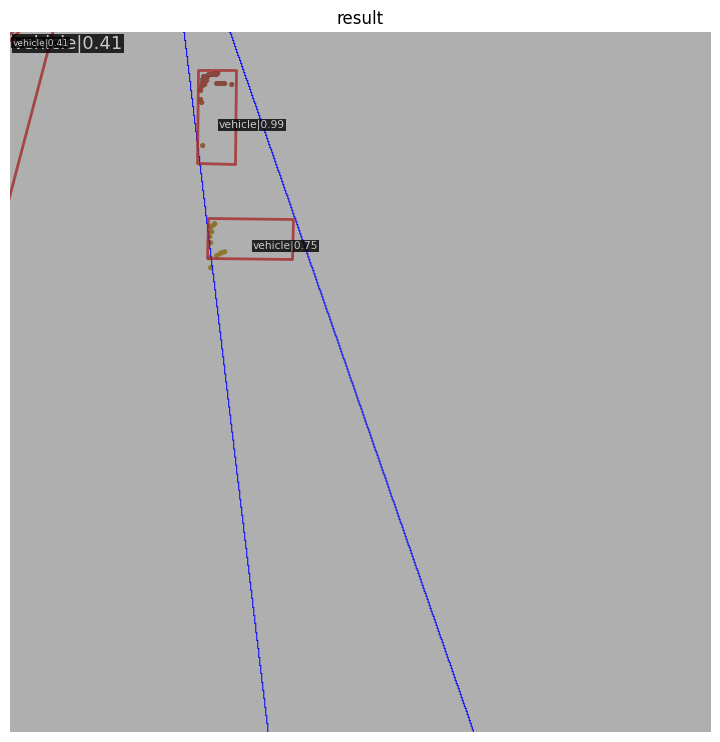

In [14]:
# Let's plot the result
show_result_pyplot(model, img, result, score_thr=0.3, palette='dota')

## Train a detector 


### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [28]:
from mmcv import Config
cfg = Config.fromfile('./Geometric3DBBox/oriented_rcnn_r50_fpn_1x_dota_le90.py')

Given a config that trains a Oriented R-CNN on DOTA dataset, we need to modify some values to use it for training Oriented R-CNN on SSDD dataset.

In [33]:
from mmdet.apis import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'LidarDataset'
cfg.data_root = './'

cfg.data.train.type = 'LidarDataset'
cfg.data.train.ann_file = './train/labelTxt'
cfg.data.train.img_prefix = './train/images'

cfg.data.val.type = 'LidarDataset'
cfg.data.val.ann_file = './val/labelTxt'
cfg.data.val.img_prefix = './val/images'

# modify num classes of the model in box head
cfg.model.roi_head.bbox_head.num_classes = 1


Config:
dataset_type = 'TinyDataset'
data_root = 'ssdd_tiny/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RResize', img_scale=(1024, 1024)),
    dict(
        type='RRandomFlip',
        flip_ratio=[0.25, 0.25, 0.25],
        direction=['horizontal', 'vertical', 'diagonal'],
        version='le90'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        flip=False,
        transforms=[
            dict(type='RResize'),
            dict(
                type='

### Train a new detector

In [ ]:
import os.path as osp

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector

# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)